# Deepwalk Implementation


In [1]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch import tensor, Tensor
from utils.deepwalk import DeepwalkModel, train_deepwalk
from torch.multiprocessing import cpu_count
from sklearn.manifold import TSNE
import pandas as pd

### Các Hyperparameter


In [2]:
EMBEDDING_SIZE = 64
WALK_LENGTH = 10
WALKS_PER_VERTEX = 10
WINDOW_SIZE = 3
START_LEARNING_RATE = 0.025
END_LEARNING_RATE = 0.001
# Tiền xử lý 1D embedding
PREPROCESS_WALKS_PER_VERTEX = 10
# Dùng cho TSNE
PERPLEXITY = 20

device và worker_threads


In [3]:
WORKER_THREADS = torch.cuda.device_count(
) if torch.cuda.is_available() else cpu_count()
WORKER_THREADS = 1
CHUNK_SIZE = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(WORKER_THREADS)

cpu
1


### Load dataset


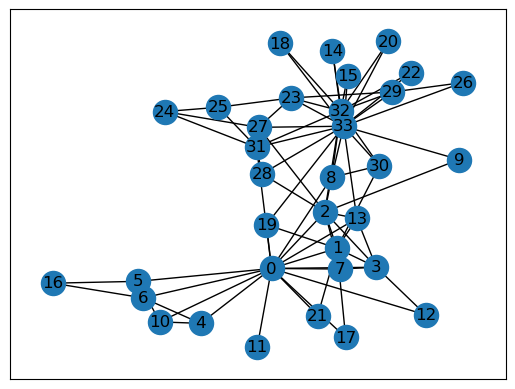

In [4]:
# Load dataset
# karate club
g: nx.Graph = nx.karate_club_graph()
adj_lists = [list(g.neighbors(v)) for v in g]
vertices = list(g)
V = len(g)
nx.draw_networkx(g)

### 1D Embedding

Embedding n-D bằng Deepwalk -> Embedding 1D bằng TSNE -> Sắp xếp lại thứ tự lá của Hierarchical Softmax


In [5]:
# ánh xạ từ đỉnh -> vị trí lá
leaf_pos = list(range(V))

# embedding sẽ được chuyển về 1 chiều bằng TSNE
model = DeepwalkModel(V=V, emb_sz=EMBEDDING_SIZE, leaf_pos=leaf_pos).to(device)
loss_records = []

if WORKER_THREADS > 1:
    model.share_memory()
train_deepwalk(
    model=model,
    start_lr=START_LEARNING_RATE,
    end_lr=(START_LEARNING_RATE + END_LEARNING_RATE) / 2.0,
    vertices=vertices,
    adj_lists=adj_lists,
    loss_records=loss_records,
    walk_len=WALK_LENGTH,
    walks_per_vertex=PREPROCESS_WALKS_PER_VERTEX,
    window_sz=WINDOW_SIZE,
    worker_threads=WORKER_THREADS,
    chunk_sz=CHUNK_SIZE,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Hàm mất mát theo epoch')

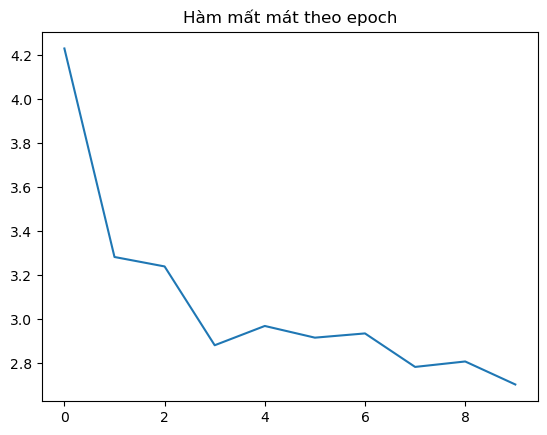

In [6]:
plt.tick_params("y")
plt.plot(loss_records)
plt.title("Hàm mất mát theo epoch")

Chyển embedding về 1 chiều bằng TSNE rồi cập nhật lại vị trí lá cho Hierarchical Softmanx


In [7]:
# chuyển embedding về 1 chiều
emb: Tensor = model.embedding_layer(tensor(list(g))).detach().cpu().numpy()
emb = TSNE(n_components=1, perplexity=PERPLEXITY).fit_transform(emb).flatten()

# sắp xếp thứ tự các đỉnh
vertices.sort(key=lambda v: emb[v])

# cập nhật thứ tự lá cho các đỉnh
for pos, v in enumerate(vertices):
    leaf_pos[v] = pos

print(emb)
print(vertices)
print(leaf_pos)

[ 1.0730697   1.6113938   0.9495589   2.0797563   2.2840593  -0.06600175
 -0.11322724  0.44758233  0.67993486  1.2172093   0.1486691   0.35501724
  1.1874926   1.6388026   1.8546418   1.8779227   1.1460023   1.2042599
  1.454201    0.9164943   0.01607162  0.32630575  1.3529743   0.47157985
  1.1449647   0.17961681 -0.6290741   0.54085606  1.890021    0.4453608
  1.4189544   1.4181839  -0.3663553   0.9178798 ]
[26, 32, 6, 5, 20, 10, 25, 21, 11, 29, 7, 23, 27, 8, 19, 33, 2, 0, 24, 16, 12, 17, 9, 22, 31, 30, 18, 1, 13, 14, 15, 28, 3, 4]
[17, 27, 16, 32, 33, 3, 2, 10, 13, 22, 5, 8, 20, 28, 29, 30, 19, 21, 26, 14, 4, 7, 23, 11, 18, 6, 0, 12, 31, 9, 25, 24, 1, 15]


### n-D Embedding


In [8]:
model = DeepwalkModel(V=V, emb_sz=EMBEDDING_SIZE, leaf_pos=leaf_pos).to(device)
loss_records = []

if WORKER_THREADS > 1:
    model.share_memory()
train_deepwalk(
    model=model,
    start_lr=START_LEARNING_RATE,
    end_lr=END_LEARNING_RATE,
    vertices=vertices,
    adj_lists=adj_lists,
    loss_records=loss_records,
    walk_len=WALK_LENGTH,
    walks_per_vertex=WALKS_PER_VERTEX,
    window_sz=WINDOW_SIZE,
    worker_threads=WORKER_THREADS,
    chunk_sz=CHUNK_SIZE,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Hàm mất mát theo epoch')

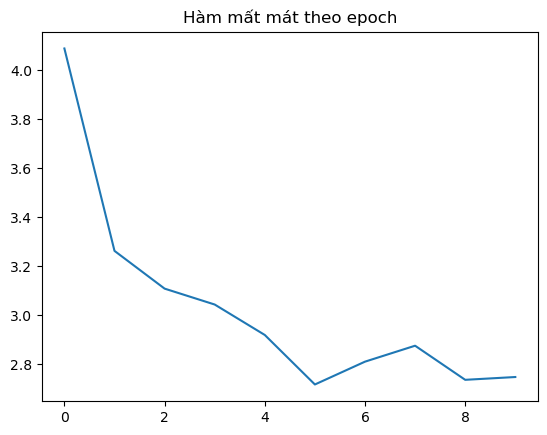

In [9]:
plt.tick_params("y")
plt.plot(loss_records)
plt.title("Hàm mất mát theo epoch")

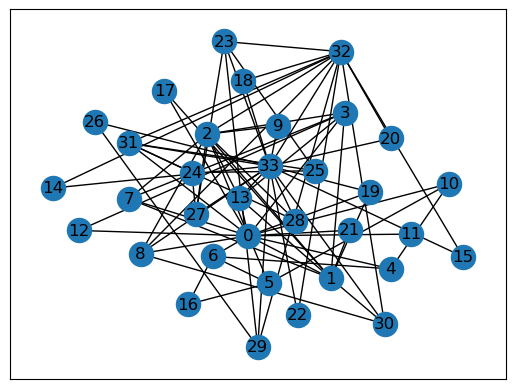

In [10]:
emb = model.embedding_layer(tensor(list(g))).detach().cpu().numpy()
emb_2d = TSNE(n_components=2, perplexity=PERPLEXITY).fit_transform(emb)
pos = {v: v_emb for v, v_emb in enumerate(emb_2d)}

nx.draw_networkx(g, pos)

In [11]:
df = pd.DataFrame(emb)
df.to_csv("out/karate_dw_emb.csv", header=False, index=False)
df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.349332,-0.066299,1.037528,0.135886,0.789283,-1.012919,0.826382,-0.577447,-0.119309,-0.956753,...,-0.388389,-0.681974,1.528689,-0.521237,0.703032,-0.294999,-0.767284,0.870389,0.279175,0.274329
1,0.996364,-0.324786,-0.503636,0.453791,-0.039914,-0.443786,0.969989,0.140675,-0.397918,0.309296,...,-1.202538,-1.127102,-0.370224,-1.460840,-0.570947,0.263282,-0.048727,0.813688,-1.984838,1.394099
2,0.142283,0.701648,2.189027,0.174698,-1.341337,1.361217,-1.042192,0.086176,0.063263,-0.906133,...,1.014118,-1.577412,1.502945,-0.132214,-0.037294,-0.295771,1.249073,0.660461,0.778631,-0.419722
3,-0.779562,-0.848957,1.348309,1.520051,0.133299,0.426447,0.545216,-0.416320,-0.474631,1.629232,...,0.068471,-1.600965,0.405713,1.145644,-0.358317,-0.200781,0.511607,-0.812775,-0.696713,-1.538412
4,0.506742,-0.688335,0.722760,0.458688,0.854423,-0.230329,0.073276,0.070337,-0.887322,0.153881,...,-2.123263,0.509022,0.408508,0.543663,-1.417902,0.350772,-1.756163,-0.391195,-0.077632,-0.026424
5,-0.707262,-0.566184,0.057715,0.427546,0.054102,0.302143,0.935072,0.004040,-0.997804,-0.403290,...,-2.127656,0.168602,-0.611866,1.010490,-1.760643,0.605572,0.085428,-0.904980,-0.131420,0.990431
6,-0.359358,0.223197,0.876978,-1.893550,0.972637,-0.999160,0.791644,0.193244,-0.187578,-0.458955,...,-0.913353,-1.397561,0.159609,-0.829377,-0.065965,0.185825,-0.536023,-1.613222,1.015189,0.520636
7,-0.456847,0.049060,2.247200,0.690119,-0.297066,-0.053475,0.112194,-1.099775,-0.022587,-0.830707,...,0.766265,1.073758,-1.173164,0.481633,0.487426,0.255682,-0.820139,-0.091557,1.155818,1.071106
8,-0.937511,2.387172,-0.639859,-0.050625,1.050177,-1.626490,-0.805235,0.199508,1.412777,-0.281499,...,-0.762637,0.381578,-1.036509,0.566248,-0.363792,-0.598526,0.117783,-1.454791,0.894768,-1.183233
9,0.181283,-0.731836,2.087054,-1.047951,0.907247,0.953623,1.285126,-0.646508,-1.231357,-1.941745,...,0.909270,-0.874606,-0.513208,2.286831,-0.856059,-0.988451,0.332906,-0.830112,0.013837,-0.570032
